##  Building a small convolutional network for Driver Distraction Dataset using VGG 16

In [148]:
from keras import layers
from keras import models
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from os import listdir, makedirs
import pandas as pd
import numpy as np

In [149]:
#driver_imgs_list.csv - a list of training images, their subject (driver) id, and class id
csv_labels = pd.read_csv('driver_distraction/driver_imgs_list.csv')
print(len(listdir('driver_distraction/imgs/train')), len(csv_labels))

(10, 22424)


In [150]:
csv_labels.groupby('classname').count()

,subject,img
classname,,
c0,2489,2489
c1,2267,2267
c2,2317,2317
c3,2346,2346
c4,2326,2326
c5,2312,2312
c6,2325,2325
c7,2002,2002
c8,1911,1911


In [151]:
csv_labels.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [152]:
csv_labels_filtered = csv_labels[(csv_labels['classname']=='c2') | (labels['classname']=='c7')]
#reaching behind (c7), talking on the phone - right (c2)

In [153]:
csv_labels_filtered['target'] = 1
df_csv_labels_filtered = csv_labels_filtered.reset_index()

/Users/ticianacoelhodasilva/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [154]:
df_csv_labels_filtered.head()

,index,subject,classname,img,target
0,150,p002,c2,img_42941.jpg,1
1,151,p002,c2,img_22889.jpg,1
2,152,p002,c2,img_101258.jpg,1
3,153,p002,c2,img_95640.jpg,1
4,154,p002,c2,img_14459.jpg,1


In [155]:
df_csv_labels_filtered['target'] = np.where(df_csv_labels_filtered['classname'] == 'c7', 0, 1)

In [156]:
df_csv_labels_filtered.tail()

,index,subject,classname,img,target
4314,22278,p081,c7,img_33152.jpg,0
4315,22279,p081,c7,img_71990.jpg,0
4316,22280,p081,c7,img_99844.jpg,0
4317,22281,p081,c7,img_5208.jpg,0
4318,22282,p081,c7,img_19521.jpg,0


In [157]:
len(df_csv_labels_filtered)

4319

In [158]:
SEED = 2000
np.random.seed(seed=SEED) #initialize the randomState
rnd = np.random.random(len(csv_labels_filtered)) #4319 float numbers between 0 and 1.
print(np.amin(rnd))
print(np.amax(rnd))

0.00018644708351078787
0.9998093271269219


In [159]:
class_list=['target']
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = df_csv_labels_filtered[class_list]
#y_train

## Loding dataset

In [160]:
from keras.preprocessing import image

def read_img(img_id, train_or_test, size, class_id):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
        class_id: class_id
    # Returns
        Image as numpy array.
    """
    if train_or_test == 'train':
        img = image.load_img(join('driver_distraction/imgs', train_or_test, '%s' % class_id, '%s' % img_id), target_size=size)
    else :
        img = image.load_img(join('driver_distraction/imgs', train_or_test, '%s' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

In [161]:
from keras.applications.vgg16 import preprocess_input
from os.path import join

INPUT_SIZE = 150

x_train = np.zeros((len(csv_labels_filtered), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32') #4319 images with 150X150X3
print(x_train.shape)
for i, index in enumerate(df_csv_labels_filtered['index']):
    img_name = df_labels.img[i]
    classname = df_labels.classname[i]
    img = read_img(img_name, 'train', (INPUT_SIZE, INPUT_SIZE), classname)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x

(4319, 150, 150, 3)


In [162]:
X_train = x_train[train_idx]
X_valid = x_train[valid_idx]

Y_train = y_train[train_idx]
Y_valid = y_train[valid_idx]
print((X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape))

((3439, 150, 150, 3), (880, 150, 150, 3), (3439, 1), (880, 1))


## Build VGG16 model

The args to initialize VGG16:
1. **weights** specifies the weight checkpoint from which to initialize the model.
2. **include_top** refers to including (or not) the densely connected classifier on top of the network. By default, this densely connected classifier corresponds to the 1,000 classes from ImageNet. Because you intend to use your own densely connected classifier (with 2 classes), you don’t need to include it.
3. **input_shape** is the shape of the image tensors that you’ll feed to the network. This argument is purely optional: if you don’t pass it, the network will be able to process inputs of any size.

In [163]:
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)) 
#Input size must be at least 48x48 and w/ 3 channels

In [164]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [211]:
conv_base.save('vgg16.h5')

In [165]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 200

def extract_features(x,y, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count, 1))
    
    generator = datagen.flow(
        x,
        y,
        batch_size=batch_size)
    
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break #Note that because generators yield data indefinitely in a loop, you must break after every image has been seen once.
    return features, labels

In [166]:
validation_features, validation_labels = extract_features(X_valid, Y_valid, 200)

In [167]:
train_features, train_labels = extract_features(X_train, Y_train, 1000)

### The extracted features are currently of shape (samples, 4, 4, 512). You’ll feed them to a densely connected classifier, so first you must flatten them to (samples, 8192):

In [168]:
train_features = np.reshape(train_features, (1000, 4*4* 512))
validation_features = np.reshape(validation_features, (200, 4*4* 512))

### At this point, you can define your densely connected classifier (note the use of dropout for regularization) and train it on the data and labels that you just recorded:

In [169]:
### Define the dense layers
from keras import models
from keras import layers
from keras import optimizers


model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30,
batch_size=20, validation_data=(validation_features, validation_labels))

Train on 1000 samples, validate on 200 samples
Epoch 1/30
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6510 - acc: 0.6060 - val_loss: 0.4611 - val_acc: 0.8500 - ETA: 4s - loss: 0.7072 - acc: 0.5937

### Training is very fast, because you only have to deal with two Dense layers—an epoch takes less than one second even on CPU. Let's look at the accuracy

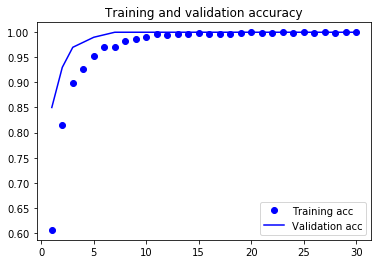

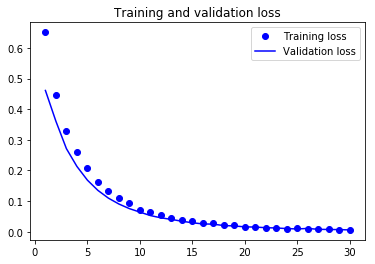

In [170]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### The plots also indicate that converge and the model capture the patterns. In case, we had overfitting, what we should change in this implementation? 

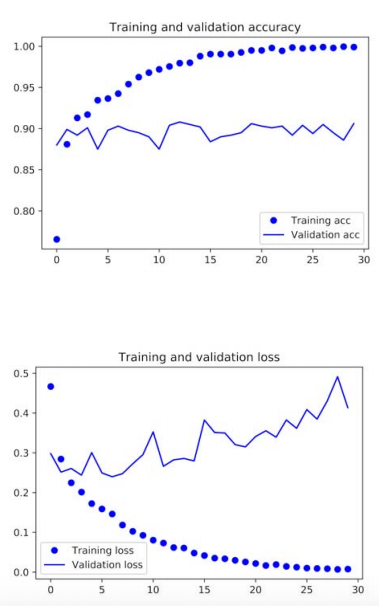

In [173]:
from IPython.display import Image
Image(filename='images/15_13.png', width=500)

Answer: Use data augmentation, which is essential for preventing overfitting with small image datasets. If you have GPU, try to use feature extraction and data augmentation during training phase.

# Fine-tuning

The steps for fine-tuning a network are as follow:
1. Add your custom network on top of an already-trained base network (done)
2. Freeze the base network (done)
3. Train the part you added (done)
4. Unfreeze some layers in the base network (**to do**)
5. Jointly train both these layers and the part you added (**to do**).

In [174]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### You’ll fine-tune the last three convolutional layers, which means all layers up to block4_pool should be frozen, and the layers block5_conv1, block5_conv2, and block5_conv3 should be trainable.

In [175]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [184]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [186]:
fine_X_train = X_train[:1000,]
fine_Y_train = Y_train[:1000]
fine_X_valid = X_valid[:200,]
fine_Y_valid = Y_valid[:200]
print(fine_X_train.shape, fine_Y_train.shape, fine_X_valid.shape, fine_Y_valid.shape)

(1000, 150, 150, 3) (1000, 1) (200, 150, 150, 3) (200, 1)


In [187]:
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-5),
metrics=['acc'])

history = model.fit(fine_X_train, fine_Y_train, epochs=1,
batch_size=500, validation_data=(fine_X_valid, fine_Y_valid))

Train on 1000 samples, validate on 200 samples
Epoch 1/1
1000/1000 [==============================] - 2590s 3s/step - loss: 0.0751 - acc: 0.9720 - val_loss: 0.5260 - val_acc: 0.9250


In [188]:
model.save('fine_tuning_vgg16.h5')

## Visualizing what convnets learn

1. Visualizing intermediate convnet outputs (intermediate activations) — Useful for **understanding how successive convnet layers transform their input**, and for getting a first idea of the meaning of individual convnet filters.
2. Visualizing convnets filters — Useful for understanding precisely what visual pattern or concept each filter in a convnet is receptive to.
3. Visualizing heatmaps of class activation in an image — Useful for understanding which parts of an image were identified as belonging to a given class, thus allowing you to localize objects in images.

In [240]:
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
from keras import models

In [241]:
model = load_model('vgg16.h5')
img_path = 'images/test.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img = image.img_to_array(img)

imag_tensor = preprocess_input(np.expand_dims(img.copy(), axis=0))

print(imag_tensor.shape)

(1, 150, 150, 3)


In [242]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [243]:
#Creates a model that will return these outputs, given the model input
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [244]:
#Returns a list of five Numpy arrays: one array per layer activation
activations = activation_model.predict(imag_tensor)
print(activations[1].shape)

(1, 150, 150, 64)


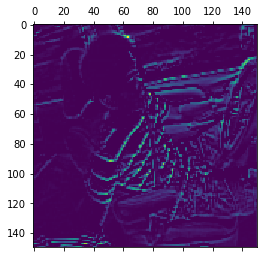

In [246]:
first_layer_activation = activations[1]
plt.matshow(first_layer_activation[0, :, :, 3])
plt.show()

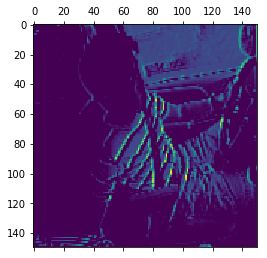

In [248]:
plt.matshow(first_layer_activation[0, :, :, 2])
plt.show()

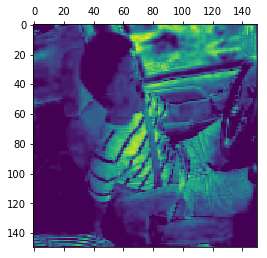

In [249]:
plt.matshow(first_layer_activation[0, :, :, 12])
plt.show()